# BNH Function Demo

In [31]:
from pathlib import Path
import shutil
import sys
sys.path.append("../..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

from examples.bnh.bnh_evaluator import BNHEvaluator
from presp.evolution import Evolution
from presp.prescriptor import DirectFactory

## Run Evolution

In [32]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

prescriptor_factory = DirectFactory(np.array(config["prescriptor_params"]["xl"]),
                                    np.array(config["prescriptor_params"]["xu"]))

evaluator = BNHEvaluator()

In [33]:
evolution = Evolution(**config["evolution_params"],
                      prescriptor_factory=prescriptor_factory,
                      evaluator=evaluator)

In [34]:
evolution.run_evolution()

Loaded 0 candidates from seed dir.


Running Evolution: 100%|██████████| 399/399 [01:03<00:00,  6.31it/s]


## Show Function Space

In [35]:
RESULTS_DIR = Path(config["evolution_params"]["save_path"])
N_GENERATIONS = config["evolution_params"]["n_generations"]

In [36]:
def get_optimal_solutions():
    x1a = np.arange(0, 3, 0.1)
    x1b = np.arange(3, 5, 0.1)

    x2a = np.arange(0, 3, 0.1)
    x2b = np.zeros(len(x1b)) + 3

    x1 = np.concatenate((x1a, x1b))
    x2 = np.concatenate((x2a, x2b))
    return x1, x2

def plot_optimal_pareto(ax: plt.Axes, evaluator: BNHEvaluator):
    x1, x2 = get_optimal_solutions()

    f1 = evaluator.f1(x1, x2)
    f2 = evaluator.f2(x1, x2)

    ax.plot(f1, f2, color="red", label="Optimal Pareto Front")
    return ax

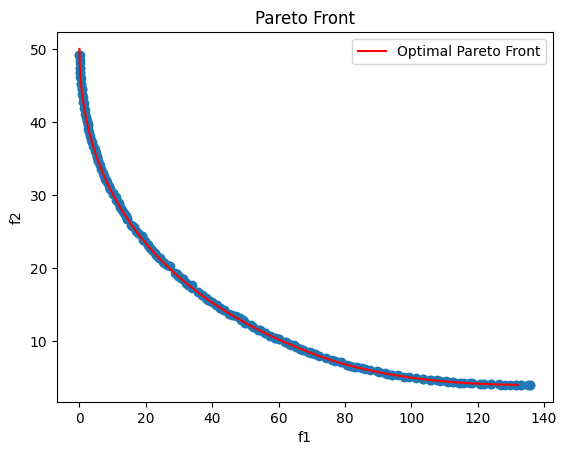

In [37]:
def plot_pareto(ax: plt.Axes, results_dir: Path, n_generations: int):
    pareto_df = pd.read_csv(results_dir / f"{n_generations}.csv")
    pareto_df = pareto_df[pareto_df["rank"] == 1]

    ax.scatter(pareto_df["f1"], pareto_df["f2"])

    return ax

fig, ax = plt.subplots()
ax = plot_optimal_pareto(ax, evaluator)
ax = plot_pareto(ax, RESULTS_DIR, N_GENERATIONS)

ax.set_xlabel("f1")
ax.set_ylabel("f2")
ax.set_title("Pareto Front")
ax.legend()
plt.show()

We can see here that we find almost the entire optimal Pareto front.

## Plot the Search Space

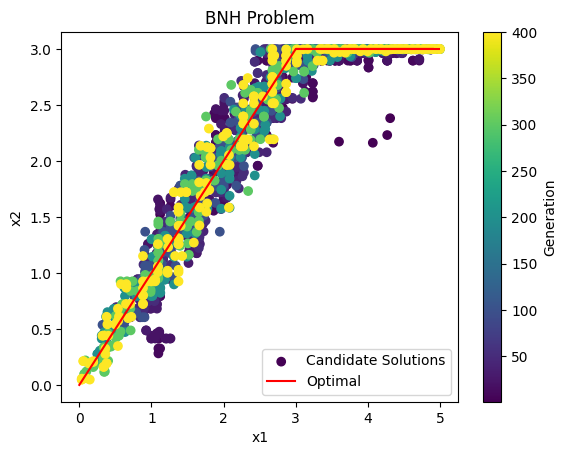

In [38]:
def plot_optimal(ax: plt.Axes):
    ax.plot(*get_optimal_solutions(), color="red", label="Optimal")
    ax.hlines(y=3, xmin=3, xmax=5, color="red")
    ax.legend()
    return ax

def plot_cand_solutions(ax: plt.Axes, results_dir: Path, gens: list[int], prescriptor_factory: DirectFactory):
    x1_col = []
    x2_col = []
    gen_col = []
    seen = set()
    for gen in gens:
        df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto_ids = df[df["rank"] == 1]["cand_id"].tolist()
        for pareto_id in pareto_ids:
            if pareto_id not in seen:
                cand = prescriptor_factory.load(results_dir / f"{pareto_id.split('_')[0]}" / f"{pareto_id}")
                x1_col.append(cand.genome[0])
                x2_col.append(cand.genome[1])
                gen_col.append(gen)
                seen.add(pareto_id)

    scatter = ax.scatter(x1_col, x2_col, c=gen_col, cmap="viridis", label="Candidate Solutions")
    ax.figure.colorbar(scatter, ax=ax, label="Generation")
    return ax

fig, ax = plt.subplots()
ax.set_title("BNH Problem")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

ax = plot_cand_solutions(ax,
                         RESULTS_DIR, 
                         [1, 10, 20, 30, 40, 50, 100, 200, 300, 400],
                         prescriptor_factory)
ax = plot_optimal(ax)
plt.show()

We can see over time our candidates converge to the true optimal solutions.

In [ ]:
# Cleanup after
shutil.rmtree(RESULTS_DIR)